In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.patches import RegularPolygon
import matplotlib.patches as mpatches
from matplotlib import cm
import numpy as np
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval
from adjustText import adjust_text

# First time we use seaborn
import seaborn as sns

from mplsoccer import Pitch, VerticalPitch, lines

from PIL import Image
import urllib
import os

from math import acos, pi
from scipy.stats import circmean
import pickle

: 

In [ ]:
import matplotlib
print(matplotlib.get_configdir())

/root/.config/matplotlib


In [ ]:
!ls /root/.config/matplotlib/stylelib

gray_style.mplstyle


In [ ]:
!ls /usr/share/fonts/

Nippo-Bold.ttf	      Nippo-Light.ttf	Nippo-Regular.ttf
Nippo-Extralight.ttf  Nippo-Medium.ttf	Nippo-Variable.ttf


In [ ]:
font_path = "/usr/share/fonts"
for x in os.listdir(font_path):
    #for y in os.listdir(f"{font_path}/{x}"):
    if x.split(".")[-1] == "ttf":
        #fm.fontManager.addfont(f"{font_path}/{x}/{y}")
        fm.fontManager.addfont(f"{font_path}/{x}")
        try:
            #fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            fm.FontProperties(weight=x.split("-")[-1].split(".")[0].lower(), fname=x.split("-")[0])
        except Exception:
            continue

# plt.style.use("gray_style")

In [ ]:
data = pd.read_csv('/work/assets/whoscored/barcelona/match/2223/eventsData/2223#26.csv', index_col=0, low_memory=False)
data['x']=data['x']*1.2
data['endX']=data['endX']*1.2
data['y']=data['y']*0.8
data['endY']=data['endY']*0.8

data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]
data['satisfied_events_types'] = [literal_eval(x) for x in data['satisfiedEventsTypes']]

In [ ]:
df = data[data['outcomeType'] == 'Successful'].reset_index(drop=True)

In [ ]:
df.loc[:, 'is_open_play'] = True
for index, record in enumerate(df['qualifiers']):
    for attr in record:
        key_search = list(attr.keys())[0]
        if key_search in ['GoalKick', 'FreekickTaken', 'CornerTaken', 'ThrowIn']:
            df.iloc[index, 'is_open_play'] = False

In [ ]:
df = df[df['is_open_play']].reset_index(drop=True)

In [ ]:
df = df.assign(dx = lambda x: x.endX - x.x)
df = df.assign(dy = lambda x: x.endY - x.y)
df = df.assign(length_pass = lambda x: (x.dx**2 + x.dy**2)**(1/2))

In [ ]:
df.dropna(subset=["dx", "dy"], inplace=True)

In [ ]:
df['angle'] = [
    acos( dx / length_pass) for dx, length_pass in zip(df['dx'], df['length_pass'])
]
df['angle'] = [
    pi + angle if dy < 0 else angle for angle, dy in zip(df['angle'], df['dy'])
]

In [ ]:
home_passes = df[df['teamId'] == 65].reset_index(drop=True)
away_passes = df[df['teamId'] != 65].reset_index(drop=True)

In [ ]:
home_passes.dropna(subset=["playerId"], inplace=True)
away_passes.dropna(subset=["playerId"], inplace=True)

In [ ]:
with open(file=f"/work/assets/whoscored/barcelona/ids/2223/2223#31.json", mode="rb") as file:
    team_players_dict = pickle.load(file)

id_name_dict = {}
for venue in team_players_dict.keys():
    for _id, _name in team_players_dict[venue].keys():
        id_name_dict[_id] = _name
        
home_passes['playerName'] = [id_name_dict[i] for i in list(home_passes['playerId'])]
home_passes['pass_recipient_id'] = home_passes['playerId'].shift(-1)
home_passes['pass_recipient'] = home_passes['playerName'].shift(-1)

away_passes['playerName'] = [id_name_dict[i] for i in list(away_passes['playerId'])]
away_passes['pass_recipient_id'] = away_passes['playerId'].shift(-1)
away_passes['pass_recipient'] = away_passes['playerName'].shift(-1)

In [ ]:
target_player_id = 279423
home_passes = home_passes[home_passes["playerId"]==target_player_id]
home_passes[["playerName", "pass_recipient", "num_passes"]]

,playerName,pass_recipient
5,Marc-André ter Stegen,Gavi
9,Marc-André ter Stegen,Eric García
60,Marc-André ter Stegen,Jules Koundé
95,Marc-André ter Stegen,Jules Koundé
98,Marc-André ter Stegen,Gavi
106,Marc-André ter Stegen,Eric García
108,Marc-André ter Stegen,Ronald Araújo
112,Marc-André ter Stegen,Sergio Busquets
142,Marc-André ter Stegen,Jules Koundé
144,Marc-André ter Stegen,Eric García


In [ ]:
home_angle = home_passes.groupby(['pass_recipient']).apply(lambda x: circmean(x.angle)).reset_index(name='angle')
home_length = home_passes.groupby(['pass_recipient'])['length_pass'].mean().reset_index()
home_size = home_passes.groupby(['pass_recipient'])['matchId'].size().reset_index(name='num_passes')

home_summary = pd.merge(home_angle, home_length, on='pass_recipient')
home_summary = pd.merge(home_summary, home_size, on='pass_recipient')

away_angle = away_passes.groupby(['pass_recipient']).apply(lambda x: circmean(x.angle)).reset_index(name='angle')
away_length = away_passes.groupby(['pass_recipient'])['length_pass'].mean().reset_index()
away_size = away_passes.groupby(['pass_recipient'])['matchId'].size().reset_index(name='num_passes')

away_summary = pd.merge(away_angle, away_length, on='pass_recipient')
away_summary = pd.merge(away_summary, away_size, on='pass_recipient')

In [ ]:
home_summary

,pass_recipient,angle,length_pass,num_passes
0,Alejandro Balde,0.760174,49.343466,1
1,Eric García,1.181881,23.885412,9
2,Franck Kessié,5.045398,26.123711,2
3,Gavi,5.080268,38.355781,2
4,Jules Koundé,3.890257,45.863395,8
5,Ronald Araújo,4.200696,27.468963,5
6,Sergio Busquets,0.556114,21.853963,3


### Pass Solar Style
In this section we detail our polar plot with some nice ticks and formatting (most of the source code comes from here).
https://github.com/rougier/scientific-visualization-book/blob/master/code/scales-projections/projection-polar-histogram.py

In [ ]:
def plot_fancy_polar(ax):
    '''
    This function plots a fancy polar chart with ticks and
    other cool aesthetics.
    '''
    # -- Remove ticks and labels.
    ax.set_thetalim(0, 2 * np.pi)
    ax.set_rlim(0, 35)
    ax.set_xticks([])
    ax.set_xticklabels([])
    # -- Aux computation for bands
    ax.set_yticks(np.linspace(0, 40, 9))
    ax.set_yticklabels([])
    ax.tick_params("both", grid_alpha=0.50, grid_zorder=-10, grid_linewidth=0.5)
    ax.set_ylabel(None)

    # -- Draw angle ticks
    radius = ax.get_rmax()
    length = 0.05 * radius
    for i in range(360):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - length],
            linewidth=0.50,
            color="0.75",
            clip_on=False,
        )
    for i in range(0, 360, 5):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - 2 * length],
            linewidth=0.75,
            color="0.75",
            clip_on=False,
        )
    # Draw edges and add annotations
    for i in range(0, 360, 90):
        angle = np.pi * i / 180
        ax.plot([angle, angle], [radius, 0], zorder=3, linewidth=1.00, color="gray")
        if i == 0:
            text_ = 'Opposition goal'
        elif i == 90:
            text_ = 'Left'
        elif i == 180:
            text_ = 'Own goal'
        else:
            text_ = 'Right'
        ax.text(
            angle,
            radius + 4 * length,
            text_,
            zorder=3,
            rotation=i - 90,
            rotation_mode="anchor",
            va="top",
            ha="center",
            size="x-small",
            family="Nippo",
            color="black",
        )

    # --  Radius ticks
    length = .5*length
    def polar_to_cartesian(theta, radius):
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.array([x, y])


    def cartesian_to_polar(x, y):
        radius = np.sqrt(x ** 2 + y ** 2)
        theta = np.arctan2(y, x)
        return np.array([theta, radius])


    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, 0.75 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], linewidth=0.50, color="gray")

    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, +1.0 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], zorder=3, linewidth=0.75, color="gray")
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, -1.0 * length]))
        text = ax.text(
            P1[0],
            P1[1],
            f'{i*1.15:.0f}',
            zorder=3,
            va="top",
            ha="center",
            size="xx-small",
            family="Nippo",
            color="gray",
        )
        text.set_path_effects(
            [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
        )


    # -- Circular bands
    n = 35
    T = np.linspace(0, 2 * np.pi, n)
    color_even = "0.95"
    increase_size = 35/7
    cutoff = 0
    while cutoff <= 35:
        if cutoff % 2 == 0:
            color = color_even
            ax.fill_between(T, cutoff, cutoff + increase_size, color=color_even, zorder=-50)
        cutoff += increase_size
    ax.scatter([0], [0], 20, facecolor="white", edgecolor="gray", zorder=1000)

In [ ]:
home_summary['annotate'] = [True if x > home_summary['num_passes'].quantile(.25) else False for x in home_summary['num_passes']] 
away_summary['annotate'] = [True if x > away_summary['num_passes'].quantile(.25) else False for x in away_summary['num_passes']]

(-0.5, 190.5, 190.5, -0.5)

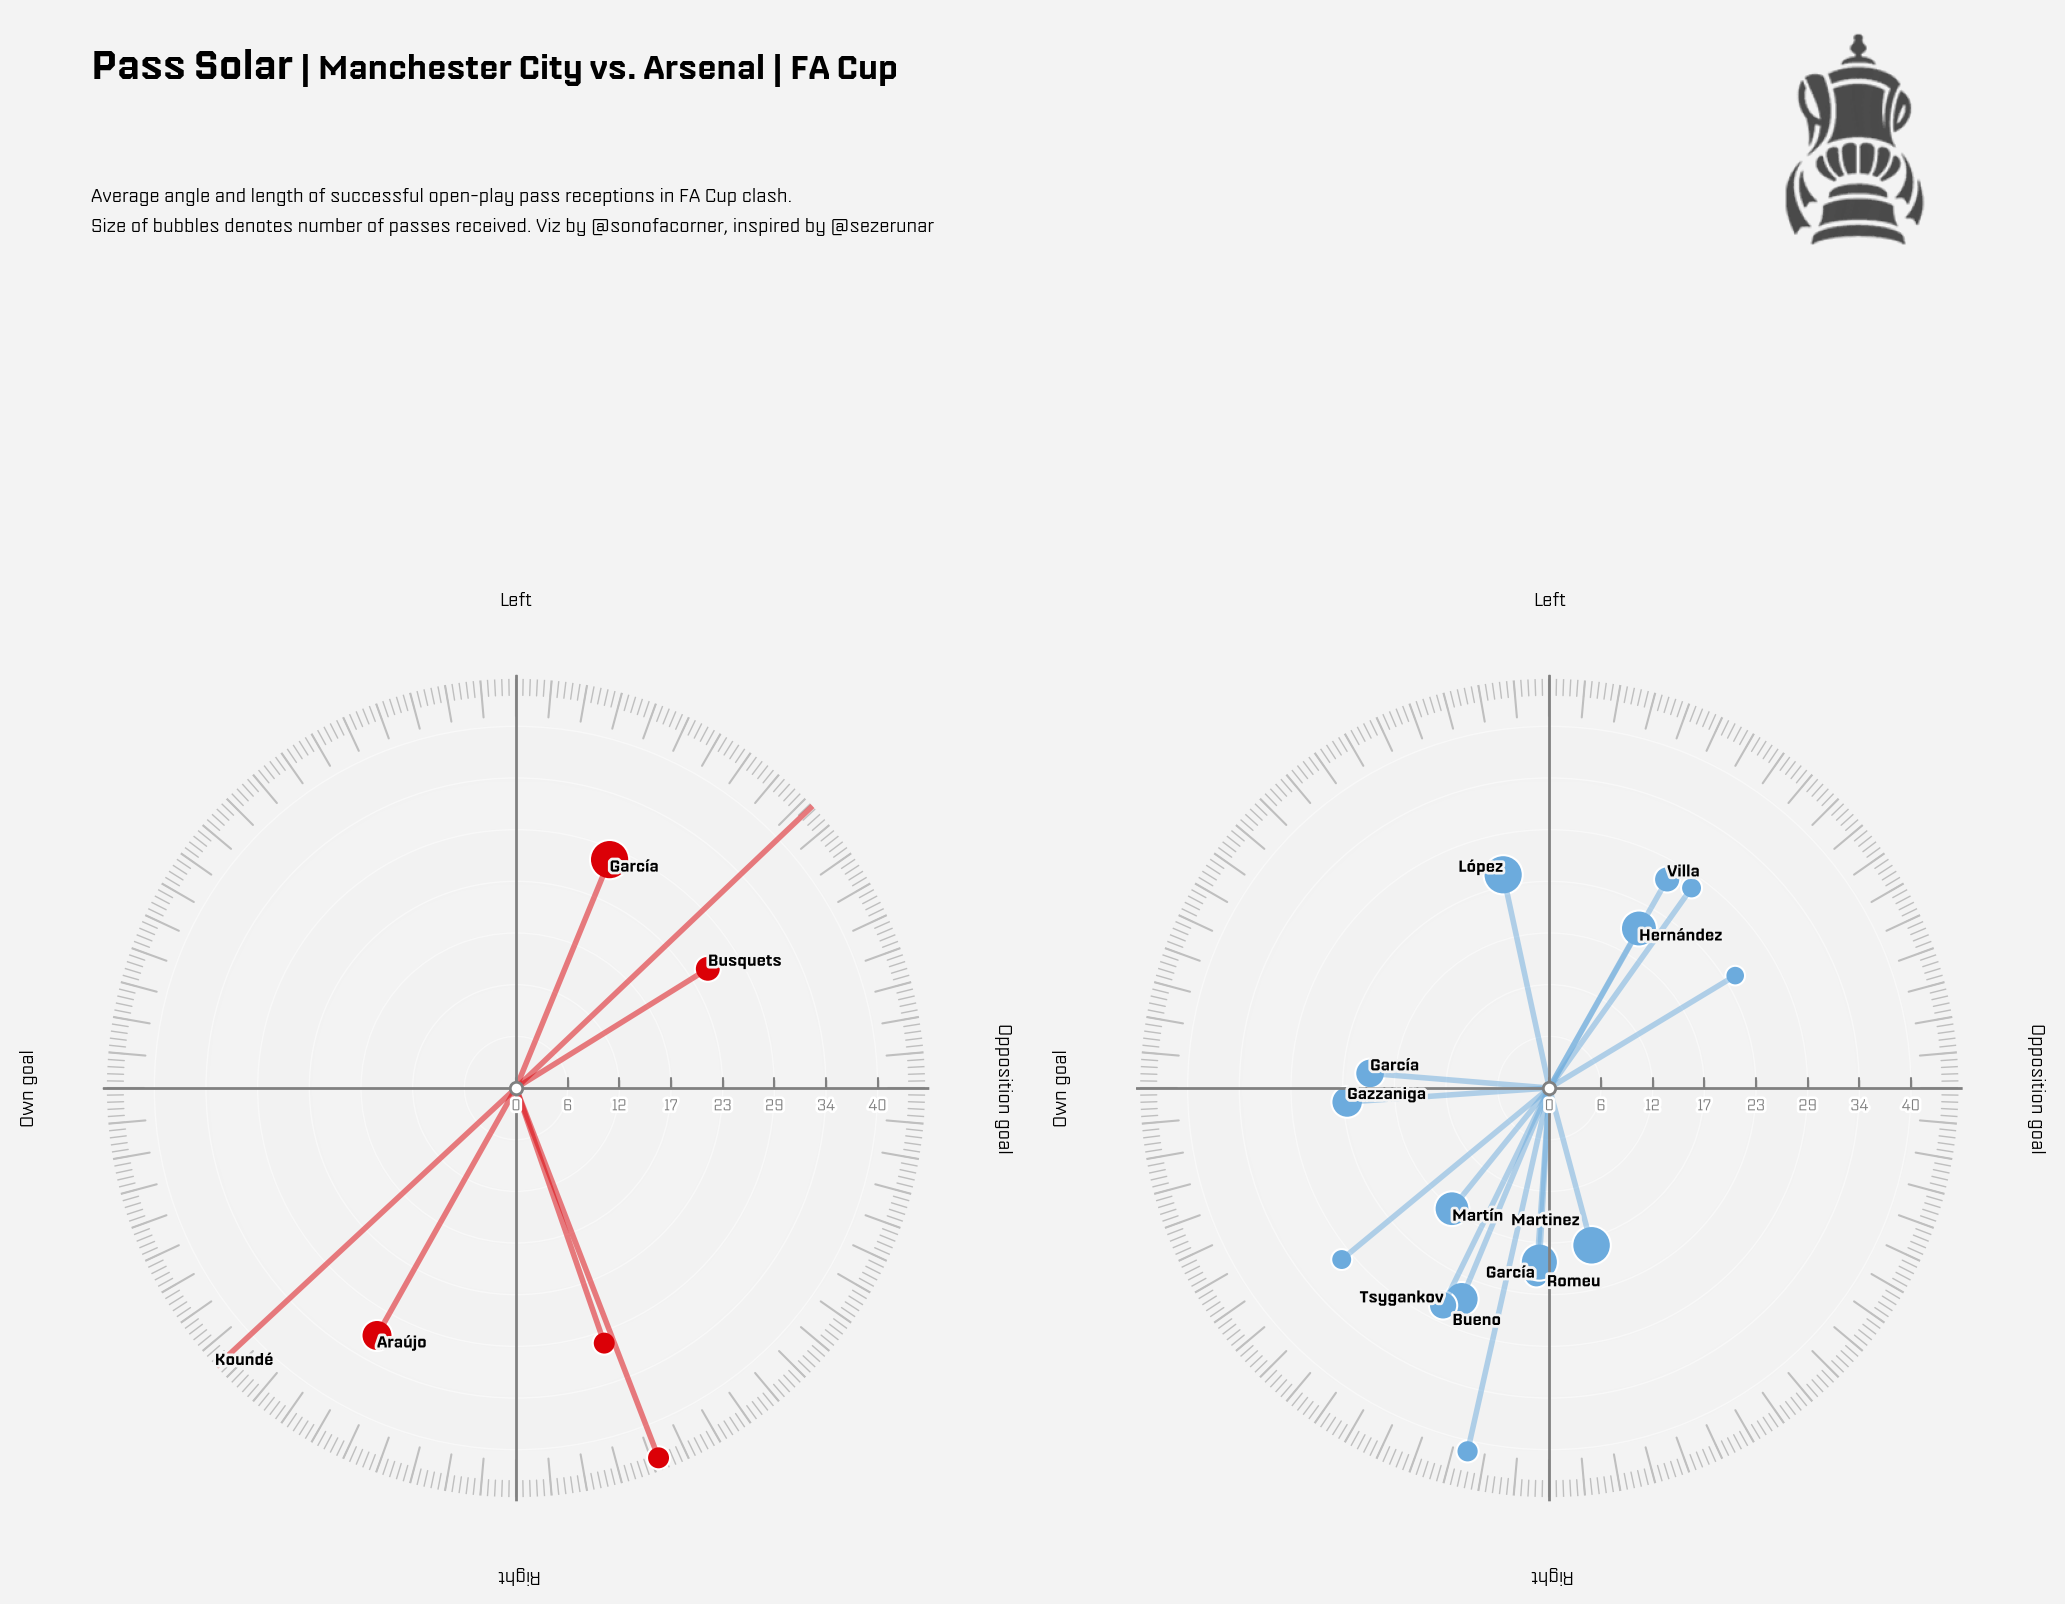

In [ ]:
fig = plt.figure(dpi=200)
ax_home = plt.subplot(1, 2, 1, projection="polar", frameon=True)
ax_away = plt.subplot(1, 2, 2, projection="polar", frameon=True)

# -- Arsenal
plot_fancy_polar(ax_home)
sns.scatterplot(
    data=home_summary, x='angle', y='length_pass', color='#DB0007',
    size='num_passes', sizes=(50,200), legend=False, ax=ax_home, zorder=2)
ax_home.set_ylabel(None)
texts = []
annotate_home = home_summary[home_summary['annotate']]
for index in range(annotate_home.shape[0]):
    player_name = annotate_home['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_home.text(
            x=annotate_home['angle'].iloc[index], y=annotate_home['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Nippo', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(home_summary['length_pass']):
    ax_home.plot(
        [0, home_summary['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color='#DB0007'
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_home)

# Away
plot_fancy_polar(ax_away)
sns.scatterplot(
    data=away_summary, x='angle', y='length_pass', color='#6CABDD',
    size='num_passes', sizes=(50,200), legend=False, ax=ax_away, zorder=2)
ax_away.set_ylabel(None)
texts = []
annotate_away = away_summary[away_summary['annotate']]
for index in range(annotate_away.shape[0]):
    player_name = annotate_away['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_away.text(
            x=annotate_away['angle'].iloc[index], y=annotate_away['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Nippo', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(away_summary['length_pass']):
    ax_away.plot(
        [0, away_summary['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color='#6CABDD'
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_away)


plt.subplots_adjust(wspace=.25, hspace=-.5)

fig_text(
    x=0.12, y=1.14, s='<Pass Solar> | Manchester City vs. Arsenal | FA Cup', family='Nippo',
    ha='left', va='center', weight='bold', size='large',
    highlight_textprops = [{'weight':'bold', 'size':'x-large'}] 
)
fig_text(
    x=0.12, y=1.05, s='Average angle and length of successful open-play pass receptions in FA Cup clash.\nSize of bubbles denotes number of passes received. Viz by @sonofacorner, inspired by @sezerunar', 
    family='Nippo',
    ha='left', va='center', size='x-small',
)

image_ax = fig.add_axes(
    [.78, 1.02, .15, .15],
    fc='None'
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/132.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}')).convert('LA')
image_ax.imshow(club_icon)
image_ax.axis('off')

# plt.savefig(
# 	"figures/02012023_pass_solar.png",
# 	dpi = 500,
# 	facecolor = "#EFE9E6",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = False
# )

# plt.savefig(
# 	"figures/02012023_pass_solar_tr.png",
# 	dpi = 500,
# 	facecolor = "none",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = True
# )

In [81]:
annotate_home
# home_summary

,pass_recipient,angle,length_pass,num_passes,annotate
0,Alejandro Balde,0.659368,13.507125,2,True
1,Ansu Fati,1.215443,12.215729,2,True
2,Eric García,0.512444,19.671831,3,True
3,Jordi Alba,5.954696,14.536153,2,True
4,Jules Koundé,4.135371,23.429716,5,True
8,Sergi Roberto,0.282192,8.376969,2,True
9,Sergio Busquets,3.663061,15.607434,3,True


In [72]:
import matplotlib.font_manager as fm
import pprint

font_list = [f.name for f in fm.fontManager.ttflist]

# pprint.pprint(font_list)

['DejaVu Sans Mono',
 'DejaVu Sans Display',
 'DejaVu Serif Display',
 'STIXGeneral',
 'DejaVu Sans',
 'STIXGeneral',
 'STIXSizeOneSym',
 'cmr10',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXSizeFourSym',
 'STIXSizeTwoSym',
 'STIXNonUnicode',
 'cmsy10',
 'STIXGeneral',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'STIXNonUnicode',
 'cmb10',
 'STIXSizeFiveSym',
 'DejaVu Serif',
 'DejaVu Sans',
 'DejaVu Sans',
 'STIXSizeThreeSym',
 'cmmi10',
 'STIXSizeFourSym',
 'STIXSizeThreeSym',
 'cmss10',
 'STIXNonUnicode',
 'STIXSizeOneSym',
 'cmex10',
 'DejaVu Sans',
 'STIXNonUnicode',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'cmtt10',
 'STIXSizeTwoSym',
 'false',
 'Nippo Variable',
 'Nippo',
 'Nippo',
 'Nippo',
 'false',
 'false',
 'Nippo Variable',
 'Nippo',
 'Nippo',
 'Nippo',
 'false']


In [26]:
from pathlib import Path
import os

In [27]:
BASE_DIR = Path("/work/assets/eventType.py").resolve().parent.parent

In [28]:
PROJECT_DIR = os.path.basename(BASE_DIR)
PROJECT_DIR

'work'

In [29]:
os.path.join(BASE_DIR, '.env')

'/work/.env'

In [30]:
BASE_DIR.joinpath(".env")

PosixPath('/work/.env')

In [31]:
BASE_DIR.name

'work'

In [32]:
str(BASE_DIR.joinpath("static"))

'/work/static'

In [33]:
os.path.join(BASE_DIR, 'static')

'/work/static'

In [34]:
os.path.join(BASE_DIR, 'staticfiles') # 
str(BASE_DIR.joinpath('staticfiles'))

'/work/staticfiles'